In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilities.preprocessors import column_summary 
from utilities.visualizers import disp_cat_feat, view_feat_outliers

%load_ext autoreload
%autoreload 2

# Read dataset
find the dataset here: https://www.kaggle.com/datasets/irakozekelly/u-s-chronic-disease-indicators-2023-release?resource=download

In [3]:
df = pd.read_csv('./data/chronic-disease-data/U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')
df

C:\Users\LARRY\AppData\Local\Temp\ipykernel_11836\1822202687.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/chronic-disease-data/U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,5,AST,AST3_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,8,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,11,AST,AST3_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,13,AST,AST3_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,NaN,Number,...,26,AST,AST3_1,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185671,2020,2020,WY,Wyoming,BRFSS,Diabetes,Dilated eye examination among adults aged >= 1...,NaN,%,Age-adjusted Prevalence,...,56,DIA,DIA7_0,AGEADJPREV,RACE,WHT,NaN,NaN,NaN,NaN
1185672,2020,2020,WY,Wyoming,BRFSS,Older Adults,Proportion of older adults aged >= 65 years wh...,NaN,%,Crude Prevalence,...,56,OLD,OLD3_1,CRDPREV,RACE,WHT,NaN,NaN,NaN,NaN
1185673,2017,2017,IA,Iowa,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,NaN,%,Age-adjusted Prevalence,...,19,ART,ART2_1,AGEADJPREV,RACE,HIS,NaN,NaN,NaN,NaN
1185674,2020,2020,WY,Wyoming,BRFSS,Diabetes,Diabetes prevalence among women aged 18-44 years,NaN,%,Crude Prevalence,...,56,DIA,DIA2_2,CRDPREV,RACE,HIS,NaN,NaN,NaN,NaN


In [4]:
column_summary(df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,YearStart,int64,0,1185676,16,"{2015: 126086, 2013: 118802, 2014: 116761, 201..."
1,YearEnd,int64,0,1185676,16,"{2015: 126086, 2017: 125300, 2013: 118802, 201..."
2,LocationAbbr,object,0,1185676,55,"{'WI': 22556, 'NY': 22556, 'NJ': 22550, 'NE': ..."
3,LocationDesc,object,0,1185676,55,"{'Wisconsin': 22556, 'New York': 22556, 'New J..."
4,DataSource,object,0,1185676,31,"{'BRFSS': 657205, 'NVSS': 175179, 'Death Certi..."
5,Topic,object,0,1185676,17,"{'Cancer': 176339, 'Cardiovascular Disease': 1..."
6,Question,object,0,1185676,203,{'Hospitalization for heart failure among Medi...
7,Response,float64,1185676,0,0,{}
8,DataValueUnit,object,152123,1033553,12,"{'%': 655776, 'cases per 100,000': 107789, 'pe..."
9,DataValueType,object,0,1185676,19,"{'Crude Prevalence': 370903, 'Age-adjusted Pre..."


In [5]:
num_cols = df.select_dtypes(include=[float, int]).columns
cat_cols = df.select_dtypes(include=[object, "datetime"]).columns

In [6]:
num_cols

Index(['YearStart', 'YearEnd', 'Response', 'DataValueAlt',
       'LowConfidenceLimit', 'HighConfidenceLimit', 'StratificationCategory2',
       'Stratification2', 'StratificationCategory3', 'Stratification3',
       'ResponseID', 'LocationID', 'StratificationCategoryID2',
       'StratificationID2', 'StratificationCategoryID3', 'StratificationID3'],
      dtype='object')

In [7]:
cat_cols

Index(['LocationAbbr', 'LocationDesc', 'DataSource', 'Topic', 'Question',
       'DataValueUnit', 'DataValueType', 'DataValue',
       'DataValueFootnoteSymbol', 'DatavalueFootnote',
       'StratificationCategory1', 'Stratification1', 'GeoLocation', 'TopicID',
       'QuestionID', 'DataValueTypeID', 'StratificationCategoryID1',
       'StratificationID1'],
      dtype='object')

In [8]:
cat_cols.shape

(18,)

#### first half of categorical columns

In [9]:
cat_cols[:cat_cols.shape[0] // 2].shape

(9,)

['#F78624', '#FB41D8', '#414C0D', '#E7C833', '#19763C', '#9360AC', '#202EEF', '#EE91CC', '#F54C35', '#33096C'] 10
<BarContainer object of 10 artists>
LocationAbbr
['#89A75D', '#7069B8', '#2AD7CD', '#019253', '#820644', '#1EEEDA', '#E2F8C2', '#791172', '#74A42E', '#D46D1A'] 10
<BarContainer object of 10 artists>
LocationDesc
['#BC16DD', '#28E124', '#E42CBF', '#1774B3', '#618CAC', '#5EB543', '#889B9A', '#B88E9C', '#0B50F3', '#291C2C'] 10
<BarContainer object of 10 artists>
DataSource
['#00B20A', '#04C55A', '#2FC8D1', '#9ACA2E', '#CA0D77', '#3DAD80', '#916D81', '#0E95A0', '#4B0E5F', '#1369DB'] 10
<BarContainer object of 10 artists>
Topic
['#82AEC3', '#B94F82', '#5E174E', '#908644', '#00E520', '#25A9B4', '#BCFC83', '#E12D0A', '#0E9180', '#E2F516'] 10
<BarContainer object of 10 artists>
Question
['#3075F0', '#7AE141', '#2E3B3B', '#486CF7', '#02135D', '#2BF392', '#C3589D', '#42C81F', '#95A7B5', '#E8160D'] 10
<BarContainer object of 10 artists>
DataValueUnit
['#5C8433', '#02BD14', '#65C3C9', 

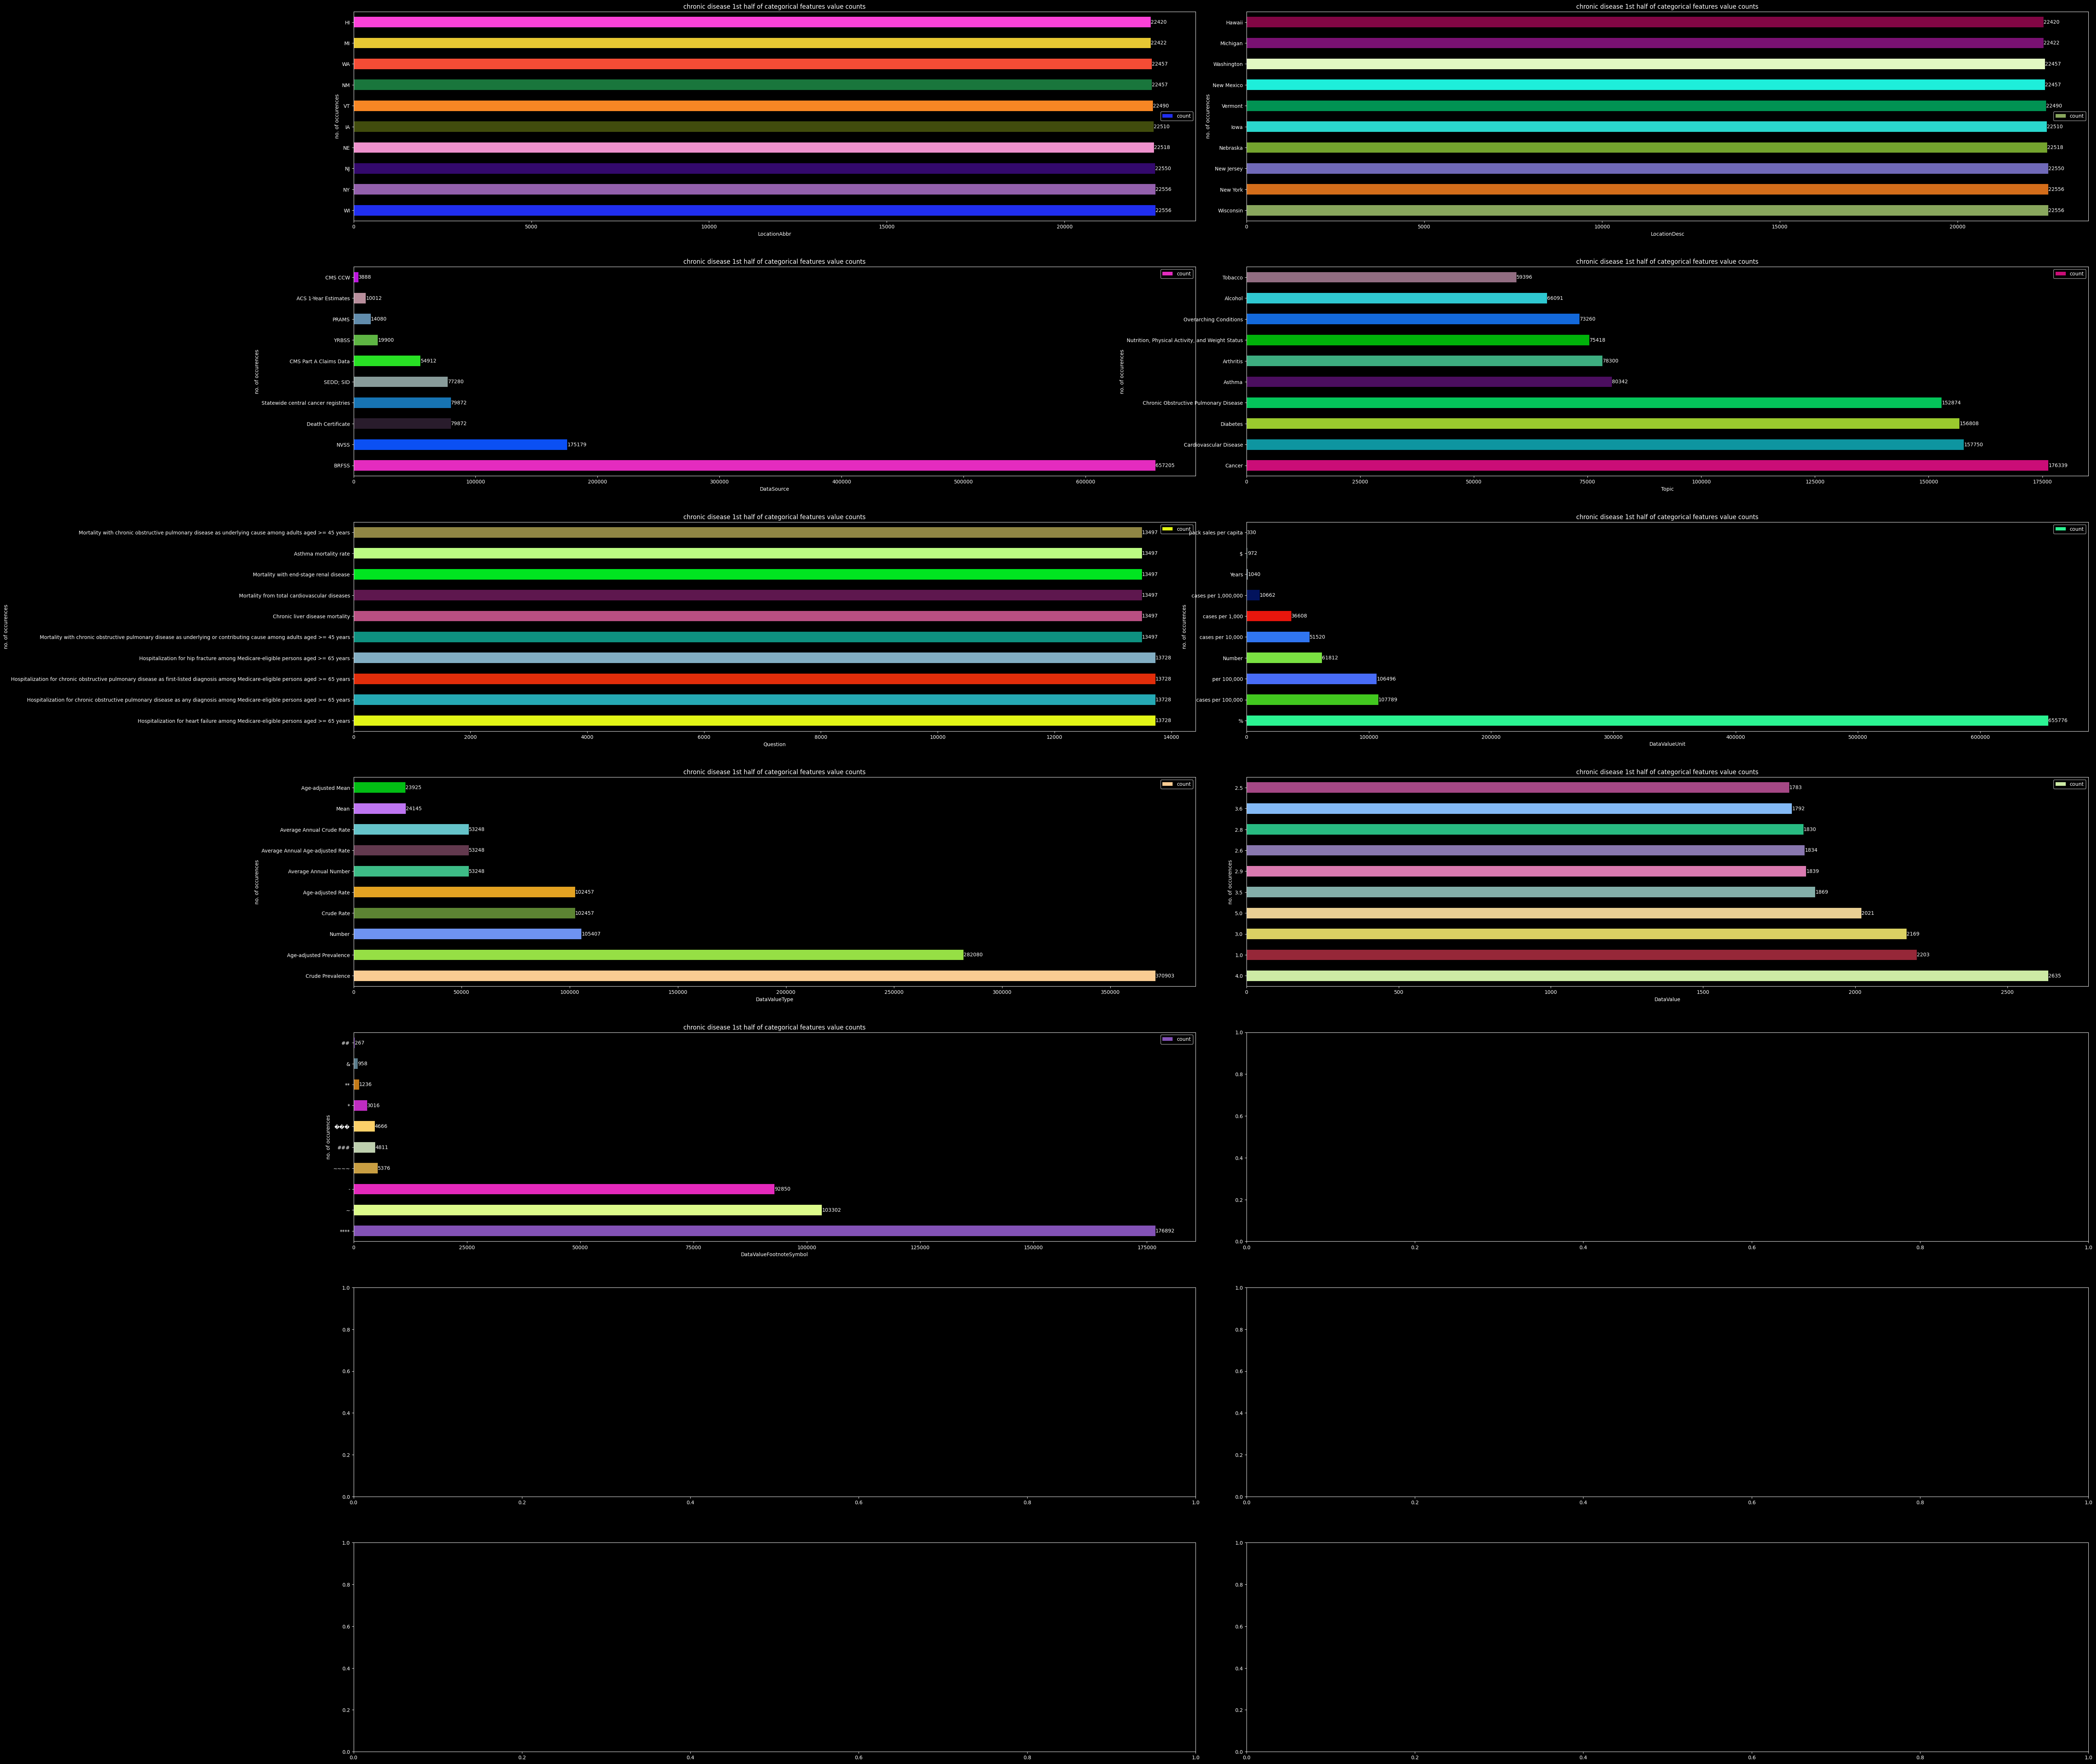

In [10]:
disp_cat_feat(df, cat_cols[:cat_cols.shape[0] // 2], fig_size=(50, 50), fig_dims=(7, 2), img_title="chronic disease 1st half of categorical features value counts")

#### second half of categorical columns

In [11]:
cat_cols[cat_cols.shape[0] // 2:].shape

(9,)

['#008B6A', '#620074', '#EC63CB', '#A24977', '#776960', '#C1289F', '#30BF3A', '#3451F3', '#5FB306', '#488A99'] 10
<BarContainer object of 10 artists>
DatavalueFootnote
['#3C1C7F', '#2574C9', '#C592C6'] 3
<BarContainer object of 3 artists>
StratificationCategory1
['#8C6844', '#8C5139', '#159D79', '#98A98A', '#A24EF0', '#9464CA', '#D10A25', '#D3396B', '#3E9B6E', '#54F248'] 10
<BarContainer object of 10 artists>
Stratification1
['#35EB2B', '#375E64', '#9F5230', '#AB68C1', '#15D5B4', '#9CCAC9', '#D3A18C', '#90CD06', '#109699', '#3E54E2'] 10
<BarContainer object of 10 artists>
GeoLocation
['#A597B8', '#5CB51D', '#ACBE6B', '#63325F', '#DDE463', '#9309B6', '#1B838E', '#F3A50F', '#1CB1C7', '#AC074D'] 10
<BarContainer object of 10 artists>
TopicID
['#8C2A64', '#5E7335', '#DAC515', '#C13279', '#EFF873', '#D0DDC1', '#161956', '#037661', '#81385A', '#BCC84A'] 10
<BarContainer object of 10 artists>
QuestionID
['#7A8DFE', '#38EE79', '#FA1C41', '#C9B5A3', '#363660', '#3C4ED2', '#631328', '#88EBE1', '

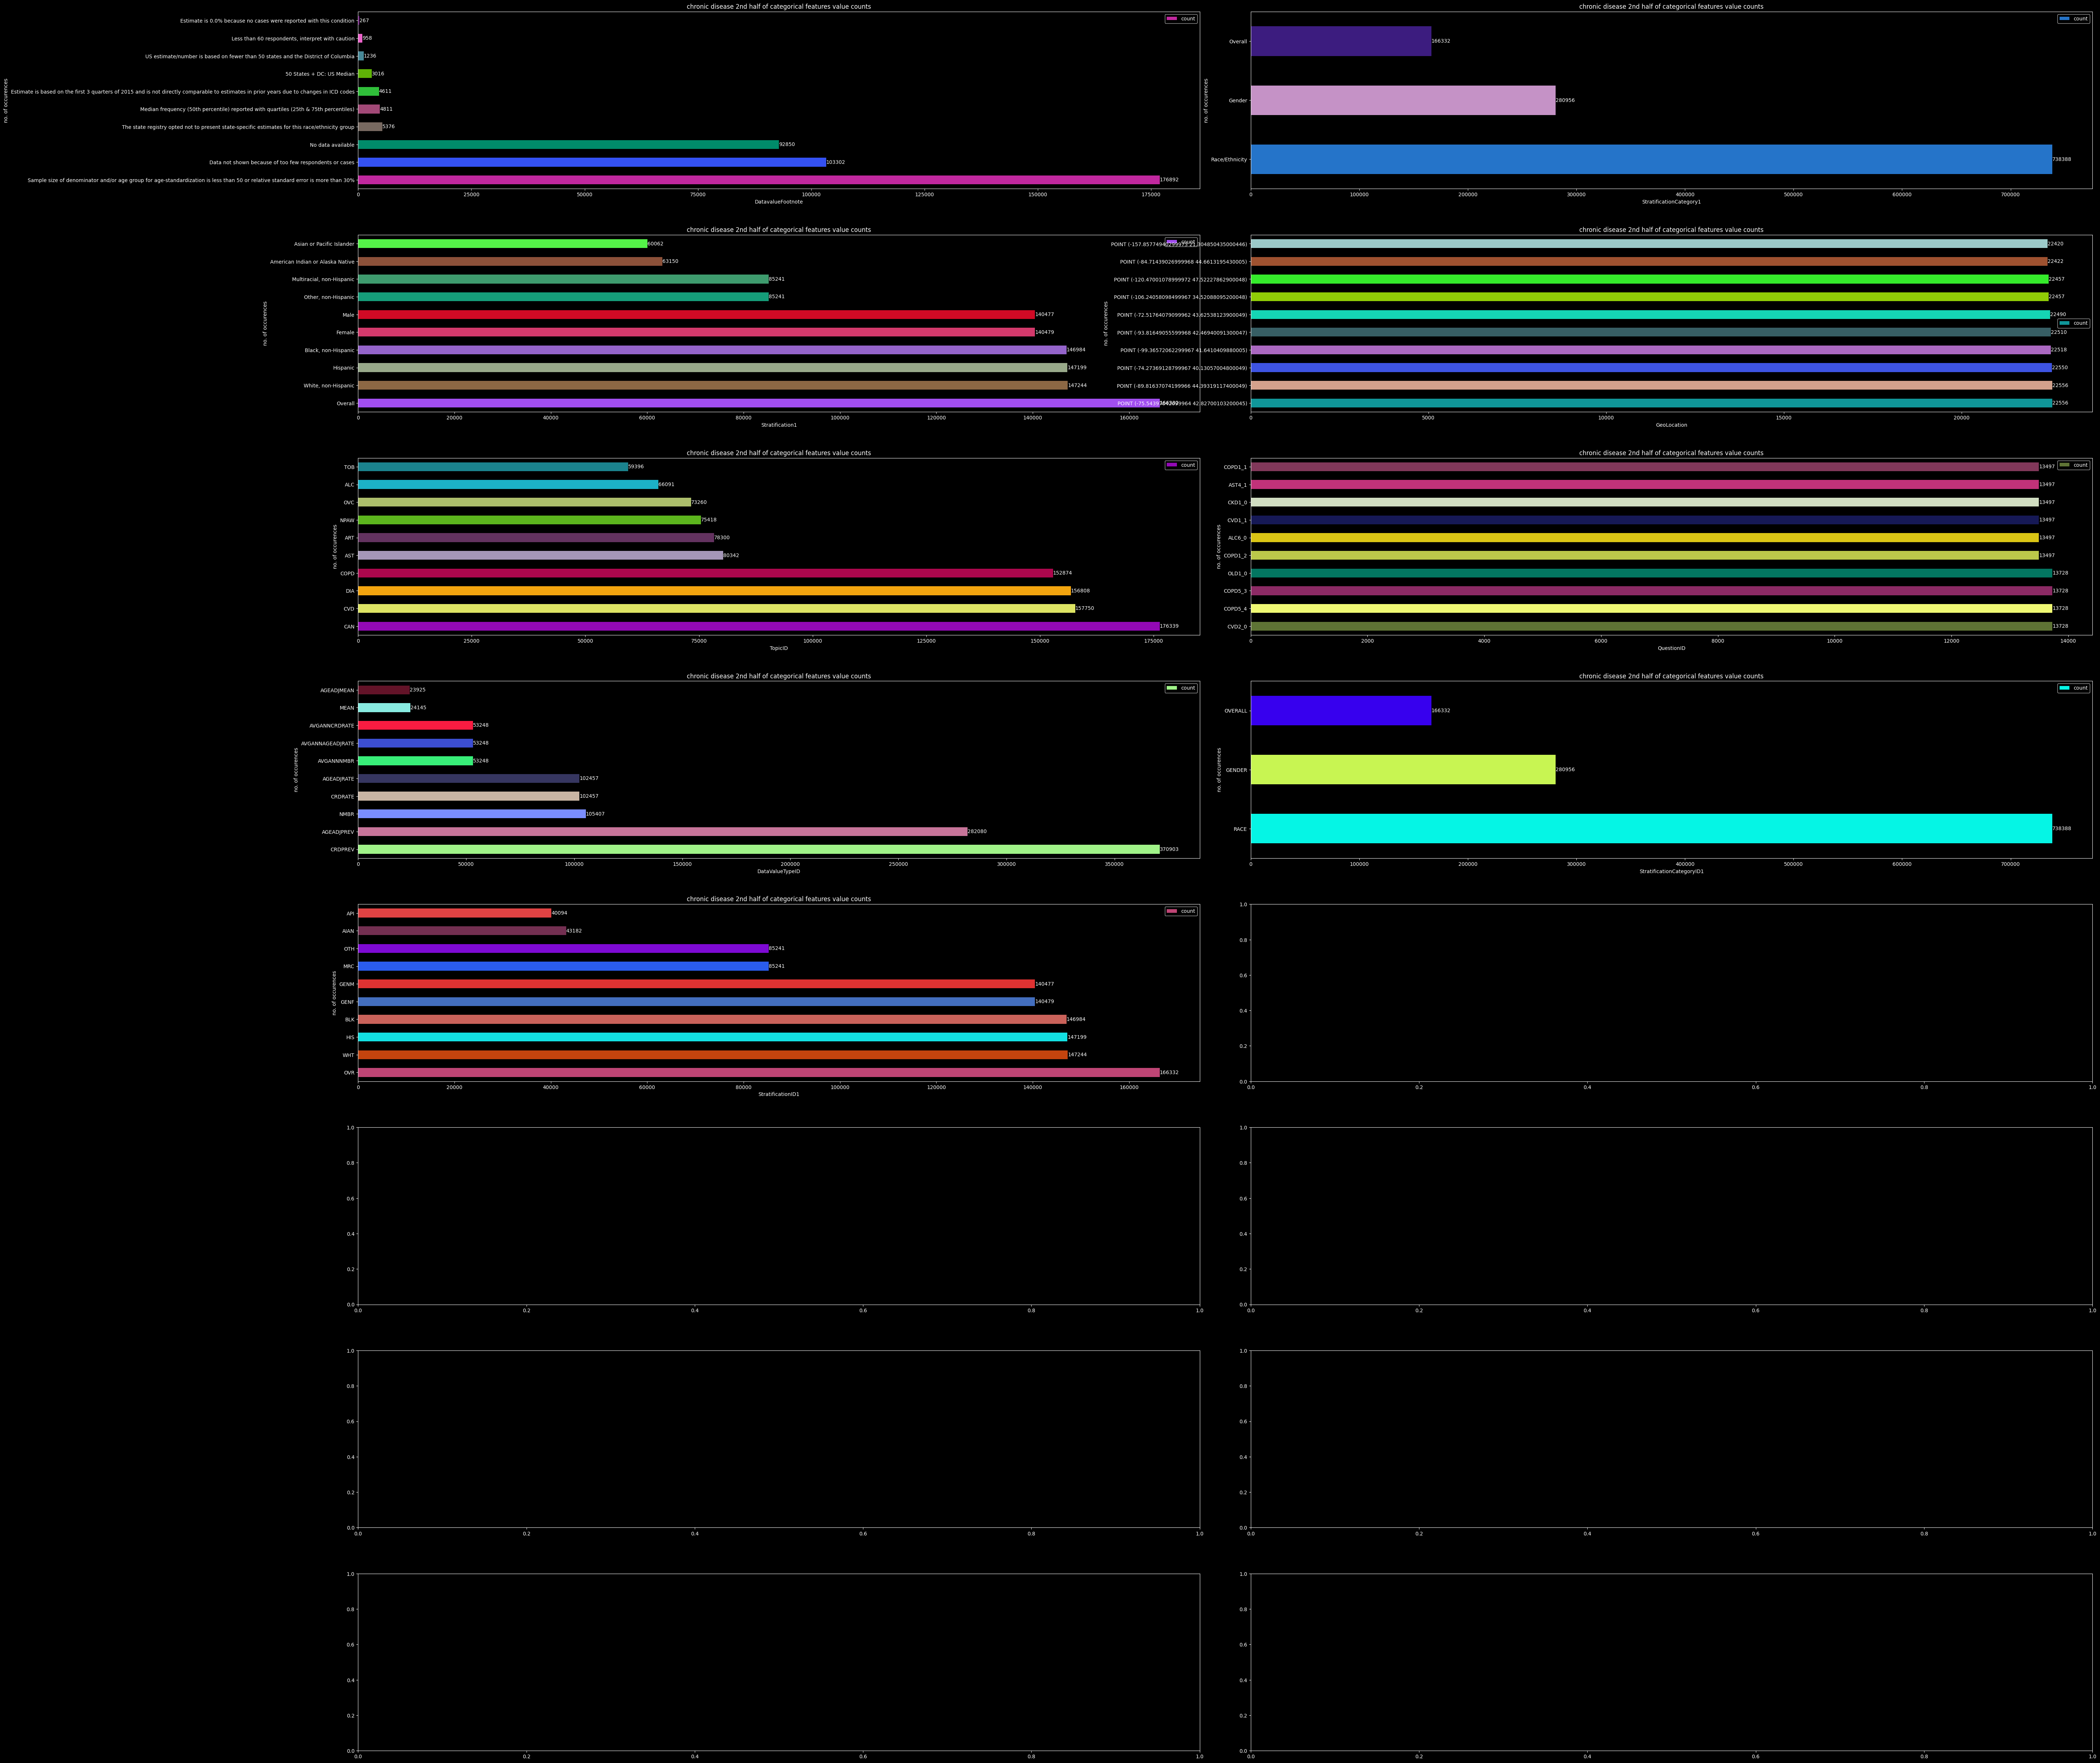

In [12]:
disp_cat_feat(df, cat_cols[cat_cols.shape[0] // 2:], fig_size=(50, 50), fig_dims=(8, 2), img_title="chronic disease 2nd half of categorical features value counts")

#### Useful columns seem to be `LocationAbbr`, `LocationDesc`, `Question`, `DataSource`, `Topic`, `Stratification1`, `StratificationCategory`, Geolocation

#### Useless columns seem to be `Response`, `DateValueFootnoteSymbol`, `DataValueFootnote`, `Stratification2`, `StratificationCategory2`, `Stratification3`, `StratificationCategory3`, `ResponseID`, `StratificationCategory1ID`, `StratificationID1`, `StratificationCategory2ID`, `StratificationID2`, `StratificationCategory3ID`, `StratificationID3`

#### Columns that could be removed but should be screened further seem to be `DataValueUnit`, `DataValueTypeID`, `DataValueType`, `DataValue`, `TopicID`, `QuestionID`, `LocationID`

In [13]:
df = df.drop(columns=["Response",
    "ResponseID",
    "DataValueFootnoteSymbol",
    "DatavalueFootnote",

    "StratificationCategory2",
    "Stratification2",
    "StratificationCategory3",
    "Stratification3",

    "StratificationCategoryID1",
    "StratificationID1",
    "StratificationCategoryID2",
    "StratificationID2",
    "StratificationCategoryID3",
    "StratificationID3"])
df = df.reset_index(drop=True)

In [14]:
df

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,916,916.0,NaN,NaN,Gender,Male,POINT (-92.27449074299966 34.74865012400045),5,AST,AST3_1,NMBR
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,2227,2227.0,NaN,NaN,Overall,Overall,POINT (-106.13361092099967 38.843840757000464),8,AST,AST3_1,NMBR
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,708,708.0,NaN,NaN,Overall,Overall,POINT (-77.036871 38.907192),11,AST,AST3_1,NMBR
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,3520,3520.0,NaN,NaN,Gender,Female,POINT (-83.62758034599966 32.83968109300048),13,AST,AST3_1,NMBR
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,123,123.0,NaN,NaN,Race/Ethnicity,Hispanic,POINT (-84.71439026999968 44.6613195430005),26,AST,AST3_1,NMBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185671,2020,2020,WY,Wyoming,BRFSS,Diabetes,Dilated eye examination among adults aged >= 1...,%,Age-adjusted Prevalence,NaN,NaN,NaN,NaN,Race/Ethnicity,"White, non-Hispanic",POINT (-108.10983035299967 43.23554134300048),56,DIA,DIA7_0,AGEADJPREV
1185672,2020,2020,WY,Wyoming,BRFSS,Older Adults,Proportion of older adults aged >= 65 years wh...,%,Crude Prevalence,41.5,41.5,38.5,44.6,Race/Ethnicity,"White, non-Hispanic",POINT (-108.10983035299967 43.23554134300048),56,OLD,OLD3_1,CRDPREV
1185673,2017,2017,IA,Iowa,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,%,Age-adjusted Prevalence,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,POINT (-93.81649055599968 42.46940091300047),19,ART,ART2_1,AGEADJPREV
1185674,2020,2020,WY,Wyoming,BRFSS,Diabetes,Diabetes prevalence among women aged 18-44 years,%,Crude Prevalence,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,POINT (-108.10983035299967 43.23554134300048),56,DIA,DIA2_2,CRDPREV


#### `Geolocation` is still a tuple, why not separate it instead into latitude and longitude values

In [15]:
geo_loc = df.iloc[0]["GeoLocation"]
geo_loc

'POINT (-92.27449074299966 34.74865012400045)'

In [16]:
import re
import ast

In [17]:
test = re.sub(r"(POINT|[/(/)])", "", geo_loc)
test = test.strip()
test = test.split(" ")
latitude, longitude = ast.literal_eval(test[0]), ast.literal_eval(test[1]) 
latitude, longitude

(-92.27449074299966, 34.74865012400045)

In [18]:
def get_lat_long(geo_loc):
    
    if pd.isna(geo_loc):
        return (np.nan, np.nan)
    
    # if geoloc is not null or nan extract its
    # longitude and latitude 
    # print(geo_loc)
    test = re.sub(r"(POINT|[/(/)])", "", geo_loc)
    test = test.strip()
    test = test.split(" ")
    latitude, longitude = ast.literal_eval(test[0]), ast.literal_eval(test[1]) 
    
    return latitude, longitude

In [19]:
lat_longs = df["GeoLocation"].apply(get_lat_long).to_list()
lat_longs

[(-92.27449074299966, 34.74865012400045),
 (-106.13361092099967, 38.843840757000464),
 (-77.036871, 38.907192),
 (-83.62758034599966, 32.83968109300048),
 (-84.71439026999968, 44.6613195430005),
 (-109.42442064499971, 47.06652897200047),
 (-120.15503132599969, 44.56744942400047),
 (-66.590149, 18.220833),
 (-66.590149, 18.220833),
 (-89.81637074199966, 44.39319117400049),
 (-89.81637074199966, 44.39319117400049),
 (-86.63186076199969, 32.84057112200048),
 (-114.3637300419997, 43.682630005000476),
 (-114.3637300419997, 43.682630005000476),
 (-88.99771017799969, 40.48501028300046),
 (-98.20078122699965, 38.34774030000045),
 (-98.20078122699965, 38.34774030000045),
 (-98.20078122699965, 38.34774030000045),
 (-92.44568007099969, 31.31266064400046),
 (-72.08269067499964, 42.27687047000046),
 (-76.60926011099963, 39.29058096400047),
 (-76.60926011099963, 39.29058096400047),
 (-94.79420050299967, 46.35564873600049),
 (-89.53803082499968, 32.745510099000455),
 (-79.15925046299964, 35.466220975

In [20]:
df["Latitude"], df["Longitude"] = list(zip(*lat_longs))

#### We can already drop `GeoLocation` as we havee already extracted the `latitude` and `longitude` values from its tuple that way we don't get any sql rollback errors anymore as we won't have to push this tuple into a database which is a datatype that does not exist

In [21]:
df.drop(columns=["GeoLocation"], inplace=True)

#### We can also drop the `topicID`, `questionID`, and `locationID` columsn as these are now irrelevant to our analysis

In [22]:
df.drop(columns=["TopicID", "QuestionID", "LocationID"], inplace=True)

In [23]:
df.head(100)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
0,2014,2014,AR,Arkansas,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,916,916.0,NaN,NaN,Gender,Male,NMBR,-92.274491,34.748650
1,2018,2018,CO,Colorado,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,2227,2227.0,NaN,NaN,Overall,Overall,NMBR,-106.133611,38.843841
2,2018,2018,DC,District of Columbia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,708,708.0,NaN,NaN,Overall,Overall,NMBR,-77.036871,38.907192
3,2017,2017,GA,Georgia,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,3520,3520.0,NaN,NaN,Gender,Female,NMBR,-83.627580,32.839681
4,2010,2010,MI,Michigan,SEDD; SID,Asthma,Hospitalizations for asthma,NaN,Number,123,123.0,NaN,NaN,Race/Ethnicity,Hispanic,NMBR,-84.714390,44.661320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2011,2015,CA,California,Death Certificate,Cancer,"Melanoma, mortality",NaN,Average Annual Number,638,638.0,NaN,NaN,Gender,Male,AVGANNNMBR,-121.000000,37.638640
96,2013,2017,CA,California,Death Certificate,Cancer,"Melanoma, mortality",NaN,Average Annual Number,608,608.0,NaN,NaN,Gender,Male,AVGANNNMBR,-121.000000,37.638640
97,2013,2017,CA,California,Death Certificate,Cancer,"Melanoma, mortality",NaN,Average Annual Number,896,896.0,NaN,NaN,Overall,Overall,AVGANNNMBR,-121.000000,37.638640
98,2011,2015,DC,District of Columbia,Death Certificate,Cancer,"Melanoma, mortality",NaN,Average Annual Number,3,3.0,NaN,NaN,Race/Ethnicity,"White, non-Hispanic",AVGANNNMBR,-77.036871,38.907192


####  Oh ok so the reason why the `topic`, `question`, `datavalueunit` and `datavalue`/`datavaluealt` columns are important is because for example the `topic` is `alchohol`, `question` is `alcohol use amoung youth?` (or more accurately what is the "count" of alcohol among youth), `datavalueunit` is `%`, and `datavalue` is `36.7` entails that *in the year 2013 in connecticut the alcohol use among youth was 36.7%*

In [24]:
df["DataValueUnit"].value_counts().index.to_list()[:10]

['%',
 'cases per 100,000',
 'per 100,000',
 'Number',
 'cases per 10,000',
 'cases per 1,000',
 'cases per 1,000,000',
 'Years',
 '$',
 'pack sales per capita']

In [25]:
df["DataValue"].value_counts().index.to_list()[:]

[4.0,
 1.0,
 3.0,
 5.0,
 3.5,
 2.9,
 2.6,
 2.8,
 3.6,
 2.5,
 2.7,
 3.4,
 3.1,
 3.7,
 7.0,
 4.1,
 3.8,
 3.3,
 3.2,
 3.9,
 6.0,
 2.4,
 4.2,
 2.3,
 4.4,
 4.3,
 8.0,
 2.2,
 1.1,
 4.5,
 2.1,
 4.6,
 1.6,
 'No',
 4.7,
 1.7,
 1.3,
 2.0,
 4.8,
 9.0,
 1.4,
 21.0,
 1.9,
 20.0,
 26.0,
 22.0,
 5.1,
 1.8,
 25.0,
 28.0,
 1.5,
 27.0,
 24.0,
 4.9,
 0.1,
 30.0,
 23.0,
 33.0,
 29.0,
 7.1,
 31.0,
 5.4,
 5.2,
 10.0,
 32.0,
 5.3,
 1.2,
 5.5,
 7.2,
 11.0,
 6.8,
 34.0,
 7.4,
 7.6,
 13.0,
 6.9,
 7.3,
 12.0,
 5.6,
 7.7,
 6.7,
 5.8,
 36.0,
 5.7,
 6.6,
 7.8,
 6.5,
 35.0,
 7.5,
 5.9,
 37.0,
 14.0,
 6.2,
 38.0,
 8.1,
 7.9,
 8.2,
 6.1,
 39.0,
 8.4,
 18.0,
 40.0,
 8.3,
 6.4,
 0.9,
 16.0,
 6.3,
 8.7,
 15.0,
 42.0,
 41.0,
 19.0,
 0.3,
 8.5,
 43.0,
 8.8,
 17.0,
 8.6,
 8.9,
 29.3,
 0.2,
 9.4,
 44.0,
 46.0,
 30.9,
 48.0,
 30.6,
 27.5,
 28.4,
 9.3,
 28.9,
 31.4,
 65.0,
 29.1,
 9.1,
 9.5,
 29.2,
 9.8,
 63.0,
 33.1,
 29.6,
 27.9,
 9.9,
 31.5,
 32.4,
 64.0,
 29.5,
 67.0,
 66.0,
 26.5,
 26.3,
 47.0,
 28.7,
 30.8,
 29.4,
 9.7,


In [26]:
df["DataValueAlt"].value_counts().index.to_list()[:10]

[4.0, 1.0, 3.0, 5.0, 3.5, 2.6, 2.8, 2.9, 2.5, 3.6]

#### Sometimes however these key columns like `datavalueunit` and `datavalue`/`datavaluealt` maybe null and so sometimes we may not need to include rows with columns that have these null values. Moreover `datavalue` has some values which are not null but instead are empty strings; these should be considered null and so cleaning the dataframe to fill in these empty strings with null values instead should be done and then convert this column to a float instead

In [27]:
def str_to_float(data_value):
    """
    converts string values of a column with "", "no"
    into nan values and string floats to real float
    values e.g. '1.4' to 1.4
    """
    try:
        return float(data_value)

    except:
        return np.nan

In [28]:
df["DataValue"] = df["DataValue"].apply(str_to_float)

In [29]:
df["DataValue"].isna().sum()

np.int64(381098)

In [30]:
df["DataValueAlt"].isna().sum()

np.int64(381098)

In [31]:
df[~df["DataValue"].isna() | ~df["DataValueAlt"].isna()].sample(n=5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
728456,2013,2013,IL,Illinois,BRFSS,"Nutrition, Physical Activity, and Weight Status",Overweight or obesity among adults aged >= 18 ...,%,Age-adjusted Prevalence,62.70,62.70,60.60,64.70,Race/Ethnicity,"White, non-Hispanic",AGEADJPREV,-88.997710,40.485010
289519,2018,2018,TX,Texas,CMS Part A Claims Data,Chronic Obstructive Pulmonary Disease,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,9.15,9.15,8.94,9.35,Gender,Male,AGEADJRATE,-99.426770,31.827240
115010,2009,2013,MT,Montana,Death Certificate,Cancer,"Invasive cancer (all sites combined), mortality","per 100,000",Average Annual Crude Rate,66.10,66.10,44.30,94.90,Race/Ethnicity,Asian or Pacific Islander,AVGANNCRDRATE,-109.424421,47.066529
642142,2016,2016,FL,Florida,BRFSS,Older Adults,Proportion of older adults aged >= 65 years wh...,%,Crude Prevalence,41.60,41.60,39.80,43.50,Overall,Overall,CRDPREV,-81.928961,28.932040
1036168,2012,2012,RI,Rhode Island,BRFSS,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years,%,Crude Prevalence,25.40,25.40,20.20,31.20,Race/Ethnicity,Hispanic,CRDPREV,-71.522470,41.708280


#### Because we already filled in the empty strings with null values instead and converted the supposed string column `datavalue` to a float instead we can drop rows with `datavalue` and `datavaluealt` columns that have null values 

In [32]:
df[df["DataValueUnit"] == "cases per 1,000,000"].sample(n=5, )

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
60189,2020,2020,RI,Rhode Island,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Age-adjusted Rate,NaN,NaN,NaN,NaN,Race/Ethnicity,Asian or Pacific Islander,AGEADJRATE,-71.522470,41.708280
42744,2020,2020,NY,New York,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Age-adjusted Rate,14.6,14.6,13.0,16.2,Overall,Overall,AGEADJRATE,-75.543970,42.827001
46311,2015,2015,CA,California,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Age-adjusted Rate,7.9,7.9,6.7,9.2,Gender,Male,AGEADJRATE,-121.000000,37.638640
48998,2014,2014,SC,South Carolina,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Crude Rate,NaN,NaN,NaN,NaN,Race/Ethnicity,Hispanic,CRDRATE,-81.045371,33.998821
38063,2018,2018,MN,Minnesota,NVSS,Asthma,Asthma mortality rate,"cases per 1,000,000",Age-adjusted Rate,9.4,9.4,7.2,12.2,Overall,Overall,AGEADJRATE,-94.794201,46.355649


#### Because `datavalueunit` also has null values we need to drop rows with these null values apart from the `datavalue` and `datavaluealt` columns. So if either the `datavalueunit` is null or `datavalue`/`datavaluealt` is null or both then we need to drop these rows. As for example `cases per 1,000,000` isn't really useful if `datavalue` is null, buti sana kung `cases per 1,000,000` and `datavalue` is `34.1` then this can be interpreted as *9 cases per 1,000,000.*

In [33]:
df = df[~df["DataValueUnit"].isna() & (~df["DataValue"].isna() & ~df["DataValueAlt"].isna())]
df

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
14,2020,2020,IL,Illinois,NVSS,Asthma,Asthma mortality rate,Number,Number,89.0,89.0,NaN,NaN,Gender,Male,NMBR,-88.997710,40.485010
17,2018,2018,KS,Kansas,NVSS,Asthma,Asthma mortality rate,Number,Number,29.0,29.0,NaN,NaN,Overall,Overall,NMBR,-98.200781,38.347740
23,2019,2019,MS,Mississippi,NVSS,Asthma,Asthma mortality rate,Number,Number,58.0,58.0,NaN,NaN,Overall,Overall,NMBR,-89.538031,32.745510
25,2020,2020,NM,New Mexico,NVSS,Asthma,Asthma mortality rate,Number,Number,26.0,26.0,NaN,NaN,Gender,Female,NMBR,-106.240581,34.520881
157,2020,2020,LA,Louisiana,NVSS,Diabetes,Mortality with diabetic ketoacidosis reported ...,Number,Number,55.0,55.0,NaN,NaN,Gender,Male,NMBR,-92.445680,31.312661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185666,2017,2017,VT,Vermont,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,%,Crude Prevalence,53.8,53.8,36.6,70.1,Race/Ethnicity,"Other, non-Hispanic",CRDPREV,-72.517641,43.625381
1185668,2019,2019,ME,Maine,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,%,Crude Prevalence,73.7,73.7,55.7,86.2,Race/Ethnicity,"Multiracial, non-Hispanic",CRDPREV,-68.985031,45.254229
1185670,2019,2019,OK,Oklahoma,BRFSS,Arthritis,Activity limitation due to arthritis among adu...,%,Crude Prevalence,57.6,57.6,47.7,66.9,Race/Ethnicity,"Other, non-Hispanic",CRDPREV,-97.521070,35.472031
1185672,2020,2020,WY,Wyoming,BRFSS,Older Adults,Proportion of older adults aged >= 65 years wh...,%,Crude Prevalence,41.5,41.5,38.5,44.6,Race/Ethnicity,"White, non-Hispanic",CRDPREV,-108.109830,43.235541


In [34]:
df["DataValueUnit"].value_counts().index.to_list()

['%',
 'cases per 100,000',
 'per 100,000',
 'Number',
 'cases per 1,000',
 'cases per 10,000',
 'cases per 1,000,000',
 'Years',
 '$',
 'gallons',
 'pack sales per capita',
 'per 100,000 residents']

In [35]:
df.loc[df["DataValueUnit"] == "per 100,000", "DataValueUnit"] = "cases per 100,000"

In [36]:
unique_data_value_units = df["DataValueUnit"].value_counts().index.to_list()
unique_data_value_units

['%',
 'cases per 100,000',
 'Number',
 'cases per 1,000',
 'cases per 10,000',
 'cases per 1,000,000',
 'Years',
 '$',
 'gallons',
 'pack sales per capita',
 'per 100,000 residents']

#### Here we can see that there are some redundant `datavalueunits` that we need to also format to be the same to each other. For instance cases per 100,000, per 100,000, (not `per 100,000 residents` since this entails close proximity unlike `per 100,000` or `cases per 100,000` which may imply differing proximities of populations). We can just update the table to have `cases per 100,000` if there are rows with `per 100,000` as its `datavalueunit` as we've done above

In [37]:
df[df["Question"] == "Chronic liver disease mortality"].sample(n=5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
30470,2012,2012,WV,West Virginia,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Age-adjusted Rate,16.4,16.4,13.9,18.8,Gender,Male,AGEADJRATE,-80.712640,38.665510
27294,2018,2018,WY,Wyoming,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Age-adjusted Rate,15.4,15.4,11.2,20.7,Gender,Female,AGEADJRATE,-108.109830,43.235541
3483,2017,2017,DE,Delaware,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Crude Rate,14.0,14.0,10.8,17.8,Gender,Male,CRDRATE,-75.577741,39.008831
6735,2020,2020,ID,Idaho,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Age-adjusted Rate,19.2,19.2,16.5,21.9,Gender,Male,AGEADJRATE,-114.363730,43.682630
24494,2019,2019,VT,Vermont,NVSS,Alcohol,Chronic liver disease mortality,"cases per 100,000",Crude Rate,7.6,7.6,4.9,11.3,Gender,Female,CRDRATE,-72.517641,43.625381


#### Another example that can be translated into insight are these rows here e.g. in 2012 in florida there were 7.7 cases per 100,000 that died from chronic disease mortality. Or 0.077% or  

In [38]:
unique_data_value_types = df["DataValueType"].value_counts().index.tolist()
unique_data_value_types

['Crude Prevalence',
 'Age-adjusted Prevalence',
 'Age-adjusted Rate',
 'Crude Rate',
 'Average Annual Age-adjusted Rate',
 'Average Annual Crude Rate',
 'Age-adjusted Mean',
 'Mean',
 'Number',
 'Median',
 'Percent',
 'Adjusted by age, sex, race and ethnicity',
 'US Dollars',
 'Per capita alcohol consumption',
 'Prevalence']

#### It seems that columns like question, datavalueunit, datavaluetype, datavalue seem to be the most important. 

In [39]:
df.groupby(by=["Question", "DataValueUnit", "DataValueType", "DataValue"]) \
.agg(new_col=("DataValue", "count")) \
.sort_values(by="new_col", ascending=False)

new_col
Question                                           DataValueUnit DataValueType           DataValue         
Median daily frequency of fruit consumption amo... Number        Median                  1.0           1458
                                                                                         1.1            563
Median daily frequency of vegetable consumption... Number        Median                  1.6            429
                                                                                         1.3            364
                                                                                         1.4            363
...                                                                                                     ...
Work limitation due to arthritis among adults a... %             Crude Prevalence        64.0             1
                                                                                         63.9             1
                                                                                         63.6             1
Activity limitation due to arthritis among adul... %             Age-adjusted Prevalence 27.5             1
                                                                                         27.0             1

[160279 rows x 1 columns]

In [40]:
df.groupby(by=["Question", "DataValueUnit", "DataValueType", "DataValue"])\
.agg(AggregationCount=("DataValue", "count"), DataValueMean=("DataValue", "mean"), DataValueSum=("DataValue", "sum"))\
.sort_values(by="AggregationCount")

AggregationCount  \
Question                                           DataValueUnit DataValueType    DataValue                     
Work limitation due to arthritis among adults a... %             Crude Prevalence 67.9                      1   
                                                                                  67.8                      1   
                                                                                  67.6                      1   
                                                                                  66.1                      1   
                                                                                  66.0                      1   
...                                                                                                       ...   
Median daily frequency of vegetable consumption... Number        Median           1.4                     363   
                                                                                  1.3                     364   
                                                                                  1.6                     429   
Median daily frequency of fruit consumption amo... Number        Median           1.1                     563   
                                                                                  1.0                    1458   

                                                                                             DataValueMean  \
Question                                           DataValueUnit DataValueType    DataValue                  
Work limitation due to arthritis among adults a... %             Crude Prevalence 67.9                67.9   
                                                                                  67.8                67.8   
                                                                                  67.6                67.6   
                                                                                  66.1                66.1   
                                                                                  66.0                66.0   
...                                                                                                    ...   
Median daily frequency of vegetable consumption... Number        Median           1.4                  1.4   
                                                                                  1.3                  1.3   
                                                                                  1.6                  1.6   
Median daily frequency of fruit consumption amo... Number        Median           1.1                  1.1   
                                                                                  1.0                  1.0   

                                                                                             DataValueSum  
Question                                           DataValueUnit DataValueType    DataValue                
Work limitation due to arthritis among adults a... %             Crude Prevalence 67.9               67.9  
                                                                                  67.8               67.8  
                                                                                  67.6               67.6  
                                                                                  66.1               66.1  
                                                                                  66.0               66.0  
...                                                                                                   ...  
Median daily frequency of vegetable consumption... Number        Median           1.4               508.2  
                                                                                  1.3               473.2  
                                                                                  1.6               686.4  
Medi

#### Stratification category will also be useful in determining the total cases. 

In [80]:
df["Stratification1"].unique()

array(['Male', 'Overall', 'Female', 'Asian or Pacific Islander',
       'White, non-Hispanic', 'Hispanic',
       'American Indian or Alaska Native', 'Black, non-Hispanic',
       'Asian, non-Hispanic', 'Other, non-Hispanic',
       'Multiracial, non-Hispanic'], dtype=object)

In [82]:
df["StratificationCategory1"].unique()

array(['Gender', 'Overall', 'Race/Ethnicity'], dtype=object)

In [81]:
df.sample(n=5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude,ID
465123,2017,2017,MI,Michigan,BRFSS,Chronic Obstructive Pulmonary Disease,Prevalence of chronic obstructive pulmonary di...,%,Age-adjusted Prevalence,13.4,13.4,12.1,14.9,Gender,Female,AGEADJPREV,-84.71439,44.661320,465124
241597,2015,2015,CA,California,ACS 1-Year Estimates,Overarching Conditions,Poverty,%,Crude Prevalence,16.4,16.4,16.2,16.6,Gender,Female,CRDPREV,-121.00000,37.638640,241598
452147,2018,2018,MI,Michigan,BRFSS,Cancer,Mammography use among women aged 50-74 years,%,Age-adjusted Prevalence,80.2,80.2,77.8,82.3,Race/Ethnicity,"White, non-Hispanic",AGEADJPREV,-84.71439,44.661320,452148
497554,2016,2016,NC,North Carolina,BRFSS,Diabetes,Pneumococcal vaccination among noninstitutiona...,%,Crude Prevalence,53.5,53.5,42.9,63.8,Race/Ethnicity,"Black, non-Hispanic",CRDPREV,-79.15925,35.466221,497555
109028,2011,2011,PA,Pennsylvania,NVSS,Chronic Kidney Disease,Mortality with end-stage renal disease,"cases per 100,000",Age-adjusted Rate,34.9,34.9,26.4,45.2,Race/Ethnicity,Asian or Pacific Islander,AGEADJRATE,-77.86070,40.793730,109029


question: Mammography use among women aged 50-74 years
data value unit: %
data value type: age-adjusted prevalence
data valueu 13.4
year start: 2018
year end: 2018
location desc: michigan
stratification: white, non hispanic

we also see here that it's not only age brackets in a question like aged >= 64 years or aged < 5 yearss but we also need to look out for ranges like 50-74 years etc.

so to make this into a tangible number these information would entail mammography use among women aged 50-74 years 

#### When the aforementioned columns are grouped we are given multiple categories of insights chronic disease occurences. But the problem is di ko pa alam pano interpret yung `age-adjusted mean`, `age-adjusted rate`, `crude mean`, `cases per 100,000`, and how these correlate with each other and how to interpret these as numerical values instead?? Gusto ko sana malaman agad yung cases per state in a country depending on their category like `activity limitation due to arthritis among adults aged >= 18 years` like how many per state yung mga tao na may ganto??

In [41]:
df.describe()

,YearStart,YearEnd,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,Latitude,Longitude
count,699340.000000,699340.000000,699340.000000,699340.000000,681850.000000,681850.000000,691045.000000,691045.000000
mean,2015.264213,2015.729772,90.717880,90.717880,50.303335,61.921614,-91.181344,39.008836
std,3.337527,3.051328,2346.636233,2346.636233,89.028597,100.128554,29.090065,6.902433
min,2001.000000,2001.000000,0.000000,0.000000,0.000000,0.000000,-157.857749,13.444304
25%,2013.000000,2013.000000,13.800000,13.800000,11.000000,16.300000,-106.133611,35.466221
50%,2015.000000,2016.000000,35.100000,35.100000,28.600000,41.000000,-89.538031,39.360700
75%,2018.000000,2018.000000,65.100000,65.100000,56.400000,71.100000,-78.457890,42.827001
max,2021.000000,2021.000000,928741.000000,928741.000000,2541.600000,3530.500000,144.793731,64.845080


#### note you don't need to be perfect and see all values, di mo kilangan kumuha pa ng extra data para pa cover yung CDI ng 2015 to present since 2001 to 2014 lang ang meron dito.

#### But it makes sense to convert `cases per 100,000`, `age-adujusted mean`, `0.90` to a meaningful absolute number to determine the cases of the chronic disease indicator and to do this we have to know the population of a state at a specific year in order to determine the accurate number of cases for the chronic disease indicator

and so it is also important to collect other data containing the US population each per state from 2001 to 2023
* https://fredaccount.stlouisfed.org/login/secure/ ~ scraped

In [42]:
df["LocationDesc"].value_counts().index.tolist()[:10]

['New York',
 'Michigan',
 'Arizona',
 'Florida',
 'North Carolina',
 'Maryland',
 'Washington',
 'Texas',
 'California',
 'Oklahoma']

In [43]:
populations_per_state_01_21_df = pd.read_csv('./data/population-data/us_populations_per_state_2001_to_2021.csv', index_col=0)
populations_per_state_01_21_df

,State,Population,Year
0,Alabama,"4,467.634",2001
1,Alaska,633.714,2001
2,Arizona,"5,273.477",2001
3,Arkansas,"2,691.571",2001
4,California,"34,479.458",2001
...,...,...,...
1066,Virginia,"8,658.910",2021
1067,Washington,"7,743.760",2021
1068,West Virginia,"1,785.618",2021
1069,Wisconsin,"5,881.608",2021


In [44]:
column_summary(populations_per_state_01_21_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,State,object,0,1071,51,"{'Alabama': 21, 'Alaska': 21, 'Arizona': 21, '..."
1,Population,object,0,1071,1071,"{'579.636': 1, '4,467.634': 1, '633.714': 1, '..."
2,Year,int64,0,1071,21,"{2001: 51, 2002: 51, 2003: 51, 2004: 51, 2005:..."


#### let's clean this populations df first to remove the commas and decimal signs in the numbers so as to be converted to an int instead

In [45]:
# clean population column
populations_per_state_01_21_df["Population"] = populations_per_state_01_21_df["Population"].apply(lambda population: int(re.sub(r"[.,]", "", population)))

In [46]:
# df = df[~pd.isna(df["LowConfidenceLimit"]) | ~pd.isna(df["HighConfidenceLimit"])]
# df

In [47]:
# df = df[~pd.isna(df["Latitude"]) | ~pd.isna(df["Longitude"])]
# df

In [48]:
column_summary(df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,YearStart,int64,0,699340,16,"{2013: 71220, 2015: 70724, 2014: 65581, 2012: ..."
1,YearEnd,int64,0,699340,15,"{2017: 72098, 2013: 71078, 2015: 70598, 2019: ..."
2,LocationAbbr,object,0,699340,55,"{'NY': 15635, 'MI': 15419, 'AZ': 15372, 'FL': ..."
3,LocationDesc,object,0,699340,55,"{'New York': 15635, 'Michigan': 15419, 'Arizon..."
4,DataSource,object,0,699340,27,"{'BRFSS': 433859, 'NVSS': 91538, 'Statewide ce..."
5,Topic,object,0,699340,17,"{'Cardiovascular Disease': 91465, 'Cancer': 90..."
6,Question,object,0,699340,192,{'Overweight or obesity among adults aged >= 1...
7,DataValueUnit,object,0,699340,11,"{'%': 428458, 'cases per 100,000': 164435, 'Nu..."
8,DataValueType,object,0,699340,15,"{'Crude Prevalence': 240209, 'Age-adjusted Pre..."
9,DataValue,float64,0,699340,25554,"{1.0: 2467, 3.5: 1924, 2.6: 1895, 2.8: 1892, 2..."


#### we can omit `latitude`, `longitude`, `lowconfidencelimit`, and `highconfidencelimit` columns that have null values as these relative to the `datavalue`, `question`, `topic`, and `datvalueunit` columns may not be as important. So we add id column to dataframe in preparation for pushing this dataframe to the local database

In [49]:
df.reset_index(inplace=True, drop=True)

In [50]:
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude
0,2020,2020,IL,Illinois,NVSS,Asthma,Asthma mortality rate,Number,Number,89.0,89.0,NaN,NaN,Gender,Male,NMBR,-88.997710,40.485010
1,2018,2018,KS,Kansas,NVSS,Asthma,Asthma mortality rate,Number,Number,29.0,29.0,NaN,NaN,Overall,Overall,NMBR,-98.200781,38.347740
2,2019,2019,MS,Mississippi,NVSS,Asthma,Asthma mortality rate,Number,Number,58.0,58.0,NaN,NaN,Overall,Overall,NMBR,-89.538031,32.745510
3,2020,2020,NM,New Mexico,NVSS,Asthma,Asthma mortality rate,Number,Number,26.0,26.0,NaN,NaN,Gender,Female,NMBR,-106.240581,34.520881
4,2020,2020,LA,Louisiana,NVSS,Diabetes,Mortality with diabetic ketoacidosis reported ...,Number,Number,55.0,55.0,NaN,NaN,Gender,Male,NMBR,-92.445680,31.312661


In [51]:
df.index + 1

RangeIndex(start=1, stop=699341, step=1)

In [52]:
df["ID"] = df.index + 1
df.head()

C:\Users\LARRY\AppData\Local\Temp\ipykernel_11836\2712008362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ID"] = df.index + 1


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,DataValueTypeID,Latitude,Longitude,ID
0,2020,2020,IL,Illinois,NVSS,Asthma,Asthma mortality rate,Number,Number,89.0,89.0,NaN,NaN,Gender,Male,NMBR,-88.997710,40.485010,1
1,2018,2018,KS,Kansas,NVSS,Asthma,Asthma mortality rate,Number,Number,29.0,29.0,NaN,NaN,Overall,Overall,NMBR,-98.200781,38.347740,2
2,2019,2019,MS,Mississippi,NVSS,Asthma,Asthma mortality rate,Number,Number,58.0,58.0,NaN,NaN,Overall,Overall,NMBR,-89.538031,32.745510,3
3,2020,2020,NM,New Mexico,NVSS,Asthma,Asthma mortality rate,Number,Number,26.0,26.0,NaN,NaN,Gender,Female,NMBR,-106.240581,34.520881,4
4,2020,2020,LA,Louisiana,NVSS,Diabetes,Mortality with diabetic ketoacidosis reported ...,Number,Number,55.0,55.0,NaN,NaN,Gender,Male,NMBR,-92.445680,31.312661,5


# Further analysis to see what combinations can we make with the unique values of the `datavaluetype` and `datavalueunit` columns in order to calculate the tangible number of chronic disease cases

In [54]:
grouped_data_value_unit_types = df.groupby(by=["DataValueUnit", "DataValueType"])\
.agg(Col1=("DataValue", "count"))\
.sort_values(by="Col1")
grouped_data_value_unit_types

Col1
DataValueUnit         DataValueType                                   
cases per 100,000     Number                                         1
%                     Prevalence                                    52
per 100,000 residents Number                                       208
pack sales per capita Number                                       306
gallons               Per capita alcohol consumption               312
$                     US Dollars                                   738
cases per 1,000,000   Adjusted by age, sex, race and ethnicity     832
                      Number                                       832
Years                 Number                                      1040
cases per 1,000,000   Age-adjusted Rate                           1718
                      Crude Rate                                  1718
%                     Percent                                     2543
Number                Number                                      4705
                      Median                                      5941
cases per 10,000      Crude Rate                                 10834
                      Age-adjusted Rate                          10834
cases per 1,000       Age-adjusted Rate                          14645
                      Crude Rate                                 14645
Number                Mean                                       18429
                      Age-adjusted Mean                          18710
cases per 100,000     Average Annual Crude Rate                  40519
                      Average Annual Age-adjusted Rate           40519
                      Crude Rate                                 41698
                      Age-adjusted Rate                          41698
%                     Age-adjusted Prevalence                   185654
                      Crude Prevalence                          240209

In [55]:
unique_data_value_unit_types = sorted(grouped_data_value_unit_types.index.tolist(), key=lambda value: value[0])
unique_data_value_unit_types

[('$', 'US Dollars'),
 ('%', 'Prevalence'),
 ('%', 'Percent'),
 ('%', 'Age-adjusted Prevalence'),
 ('%', 'Crude Prevalence'),
 ('Number', 'Number'),
 ('Number', 'Median'),
 ('Number', 'Mean'),
 ('Number', 'Age-adjusted Mean'),
 ('Years', 'Number'),
 ('cases per 1,000', 'Age-adjusted Rate'),
 ('cases per 1,000', 'Crude Rate'),
 ('cases per 1,000,000', 'Adjusted by age, sex, race and ethnicity'),
 ('cases per 1,000,000', 'Number'),
 ('cases per 1,000,000', 'Age-adjusted Rate'),
 ('cases per 1,000,000', 'Crude Rate'),
 ('cases per 10,000', 'Crude Rate'),
 ('cases per 10,000', 'Age-adjusted Rate'),
 ('cases per 100,000', 'Number'),
 ('cases per 100,000', 'Average Annual Crude Rate'),
 ('cases per 100,000', 'Average Annual Age-adjusted Rate'),
 ('cases per 100,000', 'Crude Rate'),
 ('cases per 100,000', 'Age-adjusted Rate'),
 ('gallons', 'Per capita alcohol consumption'),
 ('pack sales per capita', 'Number'),
 ('per 100,000 residents', 'Number')]

In [56]:
# run this cell with different datavaluetypes and datavalueunits to get examples
sample = df[(df["DataValueType"] == "US Dollars") & (df["DataValueUnit"] == "$")].sample()[["DataValueUnit", "Question", "DataValue"]].iloc[-1]
sample["Question"], sample["DataValueUnit"], sample["DataValue"],

('Amount of alcohol excise tax by beverage type (wine)', '$', np.float64(1.08))

#### we would have the following calculations for each unique pair of `datavalueunit` and `datavaluetype`
the most important ones that maybe indicate chronic disease would be the ff. :
* %, Prevalence e.g. `prevalence of gastrointestinal diabetes is 3.6%`
question: `so if I have a question "prevalence of gastrointestinal diabetes", datavaluetype of prevalence, datavalueunit of %, and datavalue of 3.6 which when translated would be "prevalence of gastrointestinal diabetes is 3.6%". How can I then convert this to a tangible number given the population of let's say the state of arizona in 2015 which is 18003249`
answer: $(data value / 100) * population = estimated cases$ 



* %, Percent e.g. `Live births occurring at Baby Friendly Facilities is 3.6%`
question: `so if I have a question "live births occuring at baby facilities", datavaluetype of percent, datavalueunit of %, and datavalue of 3.6 which when translated would be "live births occuring at baby facilities is 3.6%". How can I then convert this to a tangible number given the population of let's say the state of arizona in 2015 which is 18003249`
answer: To convert this percentage into a tangible number, you need: Total live births in Arizona (2015), not the total population.

Example: If Arizona had 85,000 live births in 2015, then: Births at facilities = 0.036 × 85,000 = 3,060 births. Births at facilities=0.036×85,000=3,060 births. Why not use total population? The metric is a % of births, not the general population. Most of the 18M people in Arizona (e.g., elderly, children) didn’t give birth



* %, Age-adjusted Prevalence e.g. `Current smokeless tobacco use among adults aged >= 18 years is 3.6%` (ah okay so gets ko na pag age adjusted may age number sa question)
question: `so if I have a question "Current smokeless tobacco use among adults aged >= 18 years", datavaluetype of age-adjusted prevalence, datavalueunit of %, and datavalue of 3.6 which when translated would be "Current smokeless tobacco use among adults aged >= 18 years is 3.6%". How can I then convert this to a tangible number given the population of let's say the state of arizona in 2015 which is 18003249`
answer: Step 2: Isolate the Adult Population (18+)
Since the metric applies only to adults (≥18 years), you need:

Total adult population (not total state population). Example: If adults make up ~75% of Arizona's population (2015):

Adult population = 0.75 × 18,003,249=13,502,437 adults. Adult population=0.75×18,003,249=13,502,437 adults.



* %, Crude Prevalence e.g. `Individuals meeting aerobic physical activity guidelines for substantial health benefits among adults aged >= 18 years is 3.6%`
question: `so if I have a question "prevalence of gastrointestinal diabetes", datavaluetype of prevalence, datavalueunit of %, and datavalue of 3.6 which when translated would be "prevalence of gastrointestinal diabetes is 3.6%". How can I then convert this to a tangible number given the population of let's say the state of arizona in 2015 which is 18003249`

* Number, Median e.g. `Median daily frequency of fruit consumption among adults aged >= 18 years is 3.6`
* Number, Age-adjusted Mean e.g. `Average binge drinking frequency among adults aged >= 18 yeras who binge drink is 3.6`
* Number, Mean e.g. `Average recent physically unhealthy days among adults aged >= 18 years is 3.6`
* Number, Number e.g. `Mortality from cerebrovascular disease (stroke) is 2735`

* cases per 1,000, Age-adjusted Rate e.g. `age-adjusted rate of chronic liver disease mortality is 14.4 cases per 1000`
* cases per 10,000, Age-adjusted Rate e.g. `age-adjusted rate of hospitalization for chronic obstructive pulmonary disease as any diagnosis is 178.99 cases per 10000`
* cases per 100,000, Age-adjusted Rate e.g. `age-adjusted rate of mortality from total cardiovascular diseases is 206.5 cases per 100000`
* cases per 1,000,000, Age-adjusted Rate e.g. `age-adjusted rate of asthma mortality rate is 8.3 cases per 1000000`

* cases per 1,000, Crude Rate e.g. `crude rate of hospitalization for heart failure among medicare-eligible persons aged >= 65 years is 16.5 cases per 1000`
* cases per 10,000, Crude Rate e.g. `crude rate of Emergency department visit rate for asthma is 132.33 cases per 10000`
* cases per 100,000, Crude Rate e.g. `crude rate of mortality from total cardiovascular diseases is 53 cases per 100000`
* cases per 1,000,000, Crude Rate e.g. `crude rate of asthma mortality rate is 9.3 cases per 1000000`

* cases per 1,000,000, Adjusted by age, sex, race and ethnicity e.g. `cases per 1000000 of Incidence of treated end-stage renal disease attributed to diabetes adjusted by age, sex, race and ethnicity is 156.8`
* cases per 1,000,000, Number e.g. `cases per 1000000 of Incidence of treated end-stage renal disease is 1125`

*NOTE: annual is yearly*
* cases per 100,000, Average Annual Age-adjusted Rate e.g. `Average yearly age-adjusted rate of Invasive cancer (all sites combined), mortality is 11.9 cases per 100000`
* cases per 100,000, Average Annual Crude Rate e.g. `Average yearly Crude Rate of Invasive cancer of the female breast, incidence is 13.3 cases er 100000`

* cases per 100,000, Number e.g. `mortality from heart failure is 377599 cases per 100000`
* per 100,000 residents, Number e.g. `Number of farmers markets per 100,000 residents is 7.3`

and other miscellaneous pairs would be:
* gallons, Per capita alcohol consumption e.g. per capita alchol consumption aged >= 14 years is 2.1 gallons
* pack sales per capita, Number e.g. sale of cigarette packs is 44.3 pack sales per capita
* Years, Number e.g. Life expectancy at birth is 78.2 years
* `$`, US Dollars e.g. Amount of alcohol excise tax by beverage type (wine) is 0.72$

In [57]:
match = re.search(r"aged [><]*[=]* \d+ years", "crude rate of hospitalization for heart failure among medicare-eligible persons aged > 65 years")
match[0]

'aged > 65 years'

#### It is imperative to also know the age brackets when the datavalueunit has an age adjusted unit because using the total population to calculate a tangible number out of these datavalueunits, datavaluetypes, and datavalues would not be useful for questions which measured the rates or numbers to be in a certain age bracket, and so we need to determine the population of this age bracket and only then can we calculate the estimated cases of the chronic disease for this age bracket

In [58]:
age_brackets = df["Question"].apply(lambda question: None if not re.search(r"aged [><]*[=]* \d+ years", question) else re.search(r"aged [><]*[=]* \d+ years", question)[0]).value_counts().index.tolist()
age_brackets

['aged >= 18 years',
 'aged >= 65 years',
 'aged >= 45 years',
 'aged >= 14 years']

# Because having the age adjusted populations is important to calculate the number cases in age adjusted rate values we need to somehow collate extra data that has population values per age bracket or per age. Below is all the dta scraped from 
https://www.census.gov/data/tables/time-series/demo/popest/intercensal-2000-2010-state.html
https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-detail.html
https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-detail.html
by running the notebook `extract_population_with_age_per_us_state.ipynb` followed by running the `population_experimentation.ipynb` notebook in order to model what was once incoherent excel spreadsheets into a tabular format with the age bracket, sex, state of a population 

![population data modelling 2000 to 2009 (3).png](./figures%20&%20images/population%20data%20modelling%202000%20to%202009%20(3).png)

In [59]:
populations_per_state_age_00_09_df = pd.read_csv('./data/population-data/us_populations_per_state_age_2000_to_2009.csv', index_col=0)
populations_per_state_age_00_09_df

,year,_under_5,_5_to_9,_10_to_14,_15_to_19,_20_to_24,_25_to_29,_30_to_34,_35_to_39,_40_to_44,...,_18_to_64,_18_to_24,_25_to_44,_45_to_64,_65_and_over,_16_and_over,_18_and_over,_15_to_44,sex,state
0,2000,150609,160685,165170,165156,152937,148063,148363,165784,168611,...,1342158,219519,630821,491818,232142,1639774,1574300,948914,male,Alabama
1,2001,151410,157513,166253,163598,157924,141826,148924,161913,169104,...,1349690,223054,621767,504869,234804,1650255,1584494,943289,male,Alabama
2,2002,150856,154832,166796,163527,160193,138866,149479,156961,168292,...,1357543,224916,613598,519029,236888,1660508,1594431,937318,male,Alabama
3,2003,150594,152874,167376,164178,163064,138346,149716,152711,167519,...,1369733,228598,608292,532843,240201,1675823,1609934,935534,male,Alabama
4,2004,150699,151948,167198,165836,163013,139913,147796,149728,167409,...,1380525,229249,604846,546430,242902,1689549,1623427,933695,male,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,2005,16204,15752,17150,18617,19016,15535,14928,14850,18479,...,159656,26697,63792,69167,34028,200947,193684,101425,female,Wyoming
1016,2006,16819,15919,16859,18461,19148,16650,14884,15099,17607,...,162338,26663,64240,71435,34480,204146,196818,101849,female,Wyoming
1017,2007,17882,16355,16839,18468,19377,17760,15120,15691,16780,...,165606,26835,65351,73420,35084,208067,200690,103196,female,Wyoming
1018,2008,18618,16929,17231,18513,19163,18690,15710,15978,16377,...,168422,26822,66755,74845,35928,211714,204350,104431,female,Wyoming


![population data modelling 2010 to 2019.png](./figures%20&%20images/population%20data%20modelling%202010%20to%202019.png)

In [60]:
populations_per_state_age_10_19_df = pd.read_csv('./data/population-data/us_populations_per_state_age_2010_to_2019.csv', index_col=0)
populations_per_state_age_10_19_df

,year,sex,_0,_1,_2,_3,_4,_5,_6,_7,...,_77,_78,_79,_80,_81,_82,_83,_84,_85_and_over,state
0,2010,male,30156,30481,31545,31737,31090,30927,31061,30900,...,10386,9704,8868,8372,7420,6775,6088,5266,23110,Alabama
1,2010,female,29115,29284,30509,30350,29990,29716,29670,29698,...,13913,13596,13086,12666,11591,11204,10435,9385,53133,Alabama
2,2011,male,30443,30183,30578,31646,31751,31109,30999,31135,...,10404,9791,9096,8256,7826,6819,6145,5474,24011,Alabama
3,2011,female,28723,29203,29399,30543,30360,29965,29806,29748,...,13943,13402,12851,12487,12017,10824,10485,9704,53836,Alabama
4,2012,male,29730,30522,30260,30539,31589,31789,31075,30964,...,11100,9871,9175,8459,7681,7206,6201,5537,25043,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,2017,female,3480,3447,3512,3599,3627,3508,3700,3939,...,1618,1468,1345,1269,1178,1126,1024,916,6741,Wyoming
1016,2018,male,3419,3661,3817,3882,3772,3774,3907,3817,...,1448,1361,1291,1154,1027,927,815,717,4109,Wyoming
1017,2018,female,3260,3427,3453,3496,3600,3590,3496,3657,...,1604,1555,1400,1272,1227,1110,1047,984,6801,Wyoming
1018,2019,male,3367,3415,3667,3788,3867,3737,3797,3888,...,1609,1379,1281,1218,1078,969,862,751,4128,Wyoming


In [61]:
populations_per_state_age_20_23_df = pd.read_csv('./data/population-data/us_populations_per_state_age_2020_to_2023.csv', index_col=0)
populations_per_state_age_20_23_df

,year,sex,_0,_1,_2,_3,_4,_5,_6,_7,...,_77,_78,_79,_80,_81,_82,_83,_84,_85_and_over,state
0,2020,male,29226,29793,30649,30918,31404,31427,31161,30767,...,15009,12590,11076,9931,9194,8338,7114,6371,29300,Alabama
1,2020,female,27808,28444,29270,29548,30261,30440,30093,29812,...,19130,16251,14509,13607,12813,11985,10503,9722,57072,Alabama
2,2021,male,28809,29500,29962,30875,31193,31593,31607,31411,...,14160,14069,11674,10116,9140,8311,7522,6245,29522,Alabama
3,2021,female,27932,28003,28675,29474,29746,30432,30652,30372,...,17970,18305,15264,13750,12834,11861,11040,9683,56638,Alabama
4,2022,male,29383,28991,29804,30200,31144,31366,31859,31843,...,13888,13382,13190,10782,9390,8309,7514,6728,30198,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2021,female,2956,3119,3083,3226,3364,3503,3488,3536,...,1852,1782,1518,1362,1253,1143,1054,988,6201,Wyoming
404,2022,male,3182,3126,3191,3252,3353,3572,3762,3801,...,1709,1643,1618,1323,1131,997,905,807,3964,Wyoming
405,2022,female,2814,2971,3104,3101,3252,3358,3530,3507,...,1816,1786,1686,1446,1294,1190,1058,1007,6131,Wyoming
406,2023,male,3101,3242,3136,3205,3283,3382,3585,3807,...,1707,1634,1554,1541,1235,1047,917,835,4158,Wyoming


# With the new dataframe we can import this to pgadmin4 using sqlalchemy and psycopg2 or to mysql server using sqlalchemy also and mysql_connector

In [62]:
# import psycopg2 # for pgsql
import mysql.connector as mysql_conn # for mysql
import pyodbc
import pandas as pd 
import os
from pathlib import Path
from sqlalchemy import create_engine 
from dotenv import load_dotenv

In [63]:
env_dir = Path('./').resolve()
load_dotenv(os.path.join(env_dir, '.env'))

True

#### ff. is for postgresql

In [64]:
# credentials = {
#     "user": os.environ["MY_SQL_USER"],
#     "password": os.environ["MY_SQL_PASSWORD"],
#     "host": os.environ["MY_SQL_HOST"],
#     "database": os.environ["MY_SQL_DATABASE"],
#     "port": os.environ["MY_SQL_PORT"]
# }

In [65]:
# # for postgresql only
# conn_str = f'postgresql://{user}:{password}@{host}/{database}'

In [66]:
# db = create_engine(conn_str)
# conn = db.connect()

In [67]:
# db

In [68]:
# conn

In [69]:
# conn = psycopg2.connect(conn_str)
# conn.autocommit = True
# cursor = conn.cursor()

#### for mysql

In [70]:
# credentials = {
#     "user": os.environ["MY_SQL_USER"],
#     "password": os.environ["MY_SQL_PASSWORD"],
#     "host": os.environ["MY_SQL_HOST"],
#     "database": os.environ["MY_SQL_DATABASE"],
#     "port": os.environ["MY_SQL_PORT"]
# }

In [71]:
# # for mysql only
# conn_str = 'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}'.format(**credentials)

In [72]:
# db = create_engine(conn_str)

In [73]:
# df.to_sql(
#     # name of sql table to be created in database
#     name='chronicdisease', 

#     # 
#     con=db.connect(), 
#     if_exists='replace', 

#     # Write DataFrame index as a column. Uses 'index_label' as the column name in the table.
#     # but since we already created an ID column there is no need
#     index=False,

#     # if a pendingrollbackerror is raised it is most likely due to 
#     # chunk_size parameter in to_sql(). The table may have of columns
#     # or rows, so the size of the packets being sent may be above the
#     # set threshold for the mysql database if no chunksize is set
#     chunksize=1000
# )

#### When we make queries in our mysql database via mysql server we get the ff.

```
mysql> select id, yearstart, locationdesc, topic, datavalue, latitude, longitude from chronicdisease limit 3;
+------+-----------+----------------------+---------+-----------+--------------------+--------------------+
| id   | yearstart | locationdesc         | topic   | datavalue | latitude           | longitude          |
+------+-----------+----------------------+---------+-----------+--------------------+--------------------+
|    1 |      2013 | Connecticut          | Alcohol |      36.7 |  41.56266102000046 | -72.64984095199964 |
|    2 |      2013 | District of Columbia | Alcohol |      31.4 |          38.907192 |         -77.036871 |
|    3 |      2013 | Delaware             | Alcohol |      36.3 | 39.008830667000495 | -75.57774116799965 |
+------+-----------+----------------------+---------+-----------+--------------------+--------------------+
3 rows in set (0.00 sec)
```

#### all we have to do now is be able to use this database in our notebook via our created connection using sqlalchemy

In [74]:
# conn = mysql_conn.connect(**credentials)
# conn.autocommit = True
# cursor = conn.cursor()

#### for microsoft sql server

In [75]:
credentials = {
    "user": os.environ["MS_SQL_SERVER_USER"],
    "password": os.environ["MS_SQL_SERVER_PASSWORD"],
    "host": os.environ["MS_SQL_SERVER_INSTANCE"],
    "database": os.environ["MS_SQL_SERVER_DB"],
}

In [76]:
# for mssqlserver only
conn_str = "mssql+pyodbc://{user}:{password}@{host}/{database}?" \
    "driver=ODBC+Driver+17+for+SQL+Server&TrustServerCertificate=yes".format(**credentials)

In [77]:
# conn_str

In [78]:
db = create_engine(conn_str)

#### Note if you get a `pyodbc.OperationalError: SQL Server does not exist or access denied. (17) (SQLDriverConnect); [08001] ODBC SQL Server Driver][` error it means

In [79]:
conn = db.connect()
conn

OperationalError: (pyodbc.OperationalError) ('08001', '[08001] [Microsoft][ODBC Driver 17 for SQL Server]SQL Server Network Interfaces: Error Locating Server/Instance Specified [xFFFFFFFF].  (-1) (SQLDriverConnect); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Login timeout expired (0); [08001] [Microsoft][ODBC Driver 17 for SQL Server]A network-related or instance-specific error has occurred while establishing a connection to SQL Server. Server is not found or not accessible. Check if instance name is correct and if SQL Server is configured to allow remote connections. For more information see SQL Server Books Online. (-1)')
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
# df.to_sql(
#     # name of sql table to be created in database
#     name='chronicdisease', 

#     # 
#     con=conn, 
#     if_exists='replace', 

#     # Write DataFrame index as a column. Uses 'index_label' as the column name in the table.
#     # but since we already created an ID column there is no need
#     index=False,

#     # if a pendingrollbackerror is raised it is most likely due to 
#     # chunk_size parameter in to_sql(). The table may have of columns
#     # or rows, so the size of the packets being sent may be above the
#     # set threshold for the mysql database if no chunksize is set
#     chunksize=1000
# )

In [ ]:
cnxn = pyodbc.connect(**credentials, driver="{SQL Server}")
cnxn

In [ ]:
cursor = cnxn.cursor()
cursor

#### what is the `yearstart`, `location`, `topic`, `datavalue`, `latitude`, `longitude` of an instance with the most recent year

In [ ]:
query = """
    SELECT TOP 3 id, yearstart, locationdesc, topic, datavalue, latitude, longitude FROM chronicdisease 
    WHERE yearstart = (
        SELECT TOP 1 MAX(yearstart) FROM chronicdisease
        GROUP BY yearstart
    );
"""
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[(13, 2010, 'Ohio', 'Alcohol', 12.9, -82.40426005599966, 40.06021014100048),
 (67, 2010, 'Montana', 'Alcohol', 7.5, -109.42442064499971, 47.06652897200047),
 (95, 2010, 'Arizona', 'Alcohol', 17.3, -111.76381127699972, 34.865970280000454)]

In [ ]:
pd.DataFrame.from_records(data, columns=["id", "yearstart", "locationdesc", "topic", "datavalue", "latitude", "longitude"])

,id,yearstart,locationdesc,topic,datavalue,latitude,longitude
0,13,2010,Ohio,Alcohol,12.9,-82.404260,40.060210
1,67,2010,Montana,Alcohol,7.5,-109.424421,47.066529
2,95,2010,Arizona,Alcohol,17.3,-111.763811,34.865970


# Alter imported table such that ID column is the primary key
by default a column will be nullable in sql transact not unlike mysql or psql, so we have to explicitly alter the table to be not null, and then set it as a primary key since we know primary keys cannot be null and must be unique (not unlike foreign keys which can be null or duplicated).

query to alter a tables column and to make it not null is `ALTER TABLE [<schema>].[<database>] ALTER COLUMN <column 1 name>, <column 2 name>, ..., <column n name> <data type e.g. BIGINT> NOT NULL;`

In [ ]:
query = '''
    ALTER TABLE chronicdisease ALTER COLUMN id BIGINT NOT NULL;
'''
cursor.execute(query)

In [ ]:
query = '''
    ALTER TABLE chronicdisease ADD PRIMARY KEY (id);
'''
cursor.execute(query)

# From here do any query you want

In [ ]:
query = '''
    SELECT TOP 3 * FROM chronicdisease; 
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[(2020, 2020, 'IL', 'Illinois', 'NVSS', 'Asthma', 'Asthma mortality rate', 'Number', 'Number', 89.0, 89.0, None, None, 'Gender', 'Male', 'NMBR', -88.99771017799969, 40.48501028300046, 1),
 (2018, 2018, 'KS', 'Kansas', 'NVSS', 'Asthma', 'Asthma mortality rate', 'Number', 'Number', 29.0, 29.0, None, None, 'Overall', 'Overall', 'NMBR', -98.20078122699965, 38.34774030000045, 2),
 (2019, 2019, 'MS', 'Mississippi', 'NVSS', 'Asthma', 'Asthma mortality rate', 'Number', 'Number', 58.0, 58.0, None, None, 'Overall', 'Overall', 'NMBR', -89.53803082499968, 32.745510099000455, 3)]

In [ ]:
query = '''
    SELECT DISTINCT(question) FROM chronicdisease; 
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data[:10]

[('Work limitation due to arthritis among adults aged 18-64 years who have doctor-diagnosed arthritis',),
 ('Foot examination among adults aged >= 18 years with diagnosed diabetes',),
 ('Heavy drinking among women aged 18-44 years',),
 ('Secondary schools that allow community-sponsored use of physical activity facilities by youth outside of normal school hours',),
 ('No leisure-time physical activity among adults aged >= 18 years',),
 ('Arthritis among adults aged >= 18 years',),
 ('Infants breastfed at 6 months',),
 ('Meeting aerobic physical activity guidelines among high school students',),
 ('Cholesterol screening among adults aged >= 18 years',),
 ('Television viewing among high school students',)]

In [ ]:
query = '''
    SELECT DISTINCT(datavalueunit) FROM chronicdisease; 
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[('cases per 10,000',),
 ('Years',),
 ('gallons',),
 ('$',),
 ('cases per 1,000,000',),
 ('pack sales per capita',),
 ('per 100,000 residents',),
 ('%',),
 ('cases per 100,000',),
 ('cases per 1,000',),
 ('Number',)]

In [ ]:
query = '''
    SELECT DISTINCT(datavaluetype) FROM chronicdisease;
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[('US Dollars',),
 ('Prevalence',),
 ('Crude Rate',),
 ('Per capita alcohol consumption',),
 ('Crude Prevalence',),
 ('Age-adjusted Mean',),
 ('Percent',),
 ('Age-adjusted Prevalence',),
 ('Average Annual Crude Rate',),
 ('Mean',),
 ('Adjusted by age, sex, race and ethnicity',),
 ('Median',),
 ('Age-adjusted Rate',),
 ('Average Annual Age-adjusted Rate',),
 ('Number',)]

In [ ]:
query = '''
    SELECT COUNT(datavalue) AS unique_data_value, datavalue FROM chronicdisease
    GROUP BY datavalue; 
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data[:10]

[(14, 9.57),
 (3, 99.65),
 (65, 97.0),
 (5, 426.3),
 (12, 186.3),
 (1, 1769.0),
 (2, 35.11),
 (1, 162.25),
 (1, 879.6),
 (2, 580.9)]

#### Ok so we can say if a row has a `datavalueunit` of `per 100,000 residents` and a `datavalue` of `36.7` we and the `question` is `"Heavy drinking among adults aged >= 18 years"`, it entails **heavy drinking among adult aged >= 18 years had a prevalence of 36.7 per 100,000 residents**

But I need some way to translate these into numbers somehow. And this is where using our population table which we scraped comes into play

In [ ]:
# populations_per_state_01_21_df.to_sql(
#     # name of sql table to be created in database
#     name='populationsperstate_01_21', 

#     # 
#     con=conn, 
#     if_exists='replace', 

#     # Write DataFrame index as a column. Uses 'index_label' as the column name in the table.
#     # but since we already created an ID column there is no need    
#     index=False,

#     # if a pendingrollbackerror is raised it is most likely due to 
#     # chunk_size parameter in to_sql(). The table may have of columns
#     # or rows, so the size of the packets being sent may be above the
#     # set threshold for the mysql database if no chunksize is set
#     chunksize=1000   
# )

In [ ]:
query = '''
    SELECT TOP 10 * FROM populationsperstate_01_21;
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[('Alabama', 4467634, 2001),
 ('Alaska', 633714, 2001),
 ('Arizona', 5273477, 2001),
 ('Arkansas', 2691571, 2001),
 ('California', 34479458, 2001),
 ('Colorado', 4425687, 2001),
 ('Connecticut', 3432835, 2001),
 ('Delaware', 795699, 2001),
 ('District of Columbia', 574504, 2001),
 ('Florida', 16356966, 2001)]

# Now we join the two tables based on the `chronicdisease` table's `yearstart`, `yearend`, and `locationdesc`.

In [ ]:
query = '''
    WITH a (population, state, pyear, yearstart, yearend, locaitondesc, locationabbr, datavalue, datavalueunit, datavaluetype, question) AS (
        SELECT population, state, year AS pyear, yearstart, yearend, locationdesc, locationabbr, datavalue, datavalueunit, datavaluetype, question
        FROM chronicdisease
        LEFT JOIN populationsperstate_01_21
        ON chronicdisease.locationdesc = populationsperstate_01_21.state AND chronicdisease.yearstart = populationsperstate_01_21.year
        WHERE state IS NOT NULL
    )

    SELECT TOP 10 * FROM a
    WHERE pyear = 2021
    ORDER BY population DESC; 
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[(39142565, 'California', 2021, 2021, 2021, 'California', 'CA', 29.4, '%', 'Crude Prevalence', 'Adults aged >= 18 years with arthritis who have taken a class to learn how to manage arthritis symptoms'),
 (39142565, 'California', 2021, 2021, 2021, 'California', 'CA', 19.5, '%', 'Crude Prevalence', 'Adults aged >= 18 years with arthritis who have taken a class to learn how to manage arthritis symptoms'),
 (39142565, 'California', 2021, 2021, 2021, 'California', 'CA', 19.7, '%', 'Crude Prevalence', 'Adults aged >= 18 years with arthritis who have taken a class to learn how to manage arthritis symptoms'),
 (39142565, 'California', 2021, 2021, 2021, 'California', 'CA', 0.2, '$', 'US Dollars', 'Amount of alcohol excise tax by beverage type (beer)'),
 (39142565, 'California', 2021, 2021, 2021, 'California', 'CA', 24.7, '%', 'Crude Prevalence', 'Adults aged >= 18 years with arthritis who have taken a class to learn how to manage arthritis symptoms'),
 (39142565, 'California', 2021, 2021, 2021,

# writing populations_per_state_age_00_09, populations_per_state_age_10_19, populations_per_state_age_20_23 dataframes to sql server

In [ ]:
# dfs = [
#     ("populationsperstateage_00_09", populations_per_state_age_00_09_df), 
#     ("populationsperstateage_10_19", populations_per_state_age_10_19_df), 
#     ("populationsperstateage_20_23", populations_per_state_age_20_23_df)]
# for table_name, df in dfs:
#     df.to_sql(
#         # name of sql table to be created in database
#         name=table_name, 

#         # 
#         con=conn, 
#         if_exists='replace', 

#         # Write DataFrame index as a column. Uses 'index_label' as the column name in the table.
#         # but since we already created an ID column there is no need    
#         index=False,

#         # if a pendingrollbackerror is raised it is most likely due to 
#         # chunk_size parameter in to_sql(). The table may have of columns
#         # or rows, so the size of the packets being sent may be above the
#         # set threshold for the mysql database if no chunksize is set
#         chunksize=1000   
#     )

In [ ]:
query = '''
    SELECT TOP 10 *
    FROM populationsperstateage_00_09; 
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[(2000, 150609, 160685, 165170, 165156, 152937, 148063, 148363, 165784, 168611, 153919, 140119, 108433, 89347, 76405, 63735, 46494, 27438, 18070, 575038, 293198, 131231, 1342158, 219519, 630821, 491818, 232142, 1639774, 1574300, 948914, 'male', 'Alabama'),
 (2001, 151410, 157513, 166253, 163598, 157924, 141826, 148924, 161913, 169104, 157109, 146275, 110610, 90875, 77545, 64104, 46851, 28251, 18053, 573644, 291195, 131039, 1349690, 223054, 621767, 504869, 234804, 1650255, 1584494, 943289, 'male', 'Alabama'),
 (2002, 150856, 154832, 166796, 163527, 160193, 138866, 149479, 156961, 168292, 160859, 145177, 119508, 93485, 78293, 64017, 47624, 28910, 18044, 571288, 289177, 131255, 1357543, 224916, 613598, 519029, 236888, 1660508, 1594431, 937318, 'male', 'Alabama'),
 (2003, 150594, 152874, 167376, 164178, 163064, 138346, 149716, 152711, 167519, 163830, 146758, 124704, 97551, 79768, 64399, 48391, 29601, 18042, 569488, 287311, 131583, 1369733, 228598, 608292, 532843, 240201, 1675823, 1609934, 

In [ ]:
query = '''
    SELECT TOP 10 *
    FROM populationsperstateage_10_19; 
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[(2010, 'male', 30156, 30481, 31545, 31737, 31090, 30927, 31061, 30900, 31101, 32785, 33322, 32486, 32838, 32564, 32400, 33242, 34202, 34699, 35429, 36388, 36435, 34546, 33291, 32534, 31792, 31543, 30212, 30629, 30520, 30782, 31584, 29572, 29091, 29004, 28006, 29122, 28558, 29062, 30866, 32518, 32150, 30415, 29586, 29826, 30964, 33154, 33719, 33556, 33925, 34313, 34720, 33596, 33646, 33969, 32959, 32330, 31151, 29838, 29106, 28264, 27903, 27462, 27589, 28703, 21040, 21012, 20768, 21230, 18350, 16977, 16259, 15336, 14613, 13406, 12928, 12269, 10947, 10386, 9704, 8868, 8372, 7420, 6775, 6088, 5266, 23110, 'Alabama'),
 (2010, 'female', 29115, 29284, 30509, 30350, 29990, 29716, 29670, 29698, 29972, 31412, 32009, 31333, 31332, 30897, 30943, 31594, 32335, 32738, 33984, 36210, 36696, 34764, 33354, 32371, 31961, 31954, 31172, 31318, 31416, 31572, 32258, 30563, 30200, 30109, 29033, 30133, 29717, 30745, 32133, 33737, 33227, 31487, 30818, 31001, 32116, 34413, 35120, 35352, 35658, 36224, 36368, 35

In [ ]:
query = '''
    SELECT TOP 10 *
    FROM populationsperstateage_20_23; 
'''
cursor.execute(query)

In [ ]:
data = cursor.fetchall()
data

[(2020, 'male', 29226, 29793, 30649, 30918, 31404, 31427, 31161, 30767, 31163, 31838, 32450, 33386, 34651, 34465, 33679, 33319, 33414, 32978, 32949, 34700, 34053, 33400, 33362, 32846, 32065, 31867, 32416, 32750, 33277, 33897, 33853, 32522, 31196, 30649, 30395, 30433, 29852, 30534, 30897, 30905, 30886, 29749, 29242, 29159, 28079, 28765, 28712, 29602, 31396, 33447, 32266, 30872, 30257, 30406, 31023, 32495, 33444, 33401, 33579, 33465, 32804, 32051, 31775, 31577, 30144, 29101, 28064, 26806, 25712, 24413, 23288, 22843, 22458, 23810, 16228, 15461, 15032, 15009, 12590, 11076, 9931, 9194, 8338, 7114, 6371, 29300, 'Alabama'),
 (2020, 'female', 27808, 28444, 29270, 29548, 30261, 30440, 30093, 29812, 29973, 30044, 30966, 32099, 33443, 33067, 32257, 31747, 31916, 31796, 32475, 34606, 34638, 33936, 33277, 32443, 31654, 31886, 32370, 32870, 34021, 35325, 35319, 33663, 32497, 31939, 31926, 32149, 31642, 32057, 32345, 32196, 32395, 31489, 31125, 31021, 29692, 30304, 30223, 31225, 32774, 34569, 33354, 